# Introdução

Atividade produzida para a disciplina EBM116 – Tópicos Avançados em Imagens Médicas do programa de pós-graduação em Engenharia Biomédica da Universidade Federal do ABC (UFABC). O objetivo da atividade foi aplicar um cálculo de interpolação e explorar a técnica de reconstrução tomográfica.

Autor: Leonardo Alves Ferreira

# Sumário

1. [Interpolação](#ex1) <br>
2. [Reconstrução Tomográfica](#ex2) <br>

# Interpolação <a name="ex1"></a>

Dados quatro coordendas discretas $(x_0,y_0)$, $(x_1,y_0)$, $(x_1,y_0)$ e $(x_1,y_1)$, e uma função $f(x_i,y_j)=\rho$ que mapeie esses pontos para valores de intensidade, podemos encontrar o valor de intensidade de $f(x,y)$ em uma região intermediária na região formada por esses quatro pontos utilizando a interpolação bilinear. Esse procedimento pode ser realizado primeiramente interpolando os valores em x para as duas alturas y:

\begin{equation*}
    f(x,y_0)= \frac{x_1 - x}{x_1 - x_0} f(x_0,y_0) + \frac{x - x_0}{x_1 - x_0} f(x_1,y_0)
\end{equation*}

e

\begin{equation*}
    f(x,y_1)= \frac{x_1 - x}{x_1 - x_0} f(x_0,y_1) + \frac{x - x_0}{x_1 - x_0} f(x_1,y_1).
\end{equation*}

Com esses valores, interpolamos em y para encontrar o resultado final:

\begin{equation*}
    f(x,y)= \frac{y_1 - y}{y_1 - y_0} f(x,y_0) + \frac{y - y_0}{y_1 - y_0} f(x_1,y_1).
\end{equation*}

Para facilitar a notação, iremos considerar a notação $f(a,b) = \rho_{ab}$. Dados os pontos $\rho_{00}=0$, $\rho_{01}=5$, $\rho_{10}=6$ e $\rho_{11}=7$, iremos realizar a interpolação bilinear para encontrar o valor aproximado nas coordenadas (0.2,0.9) e (0.6,0.3). 

In [7]:
# Primeiro caso (0.2, 0.9)
# interpolando em x
r_x0=(1-0.2)/(1-0)*0 + (0.2-0)/(1-0)*6
r_x1=(1-0.2)/(1-0)*5 + (0.2-0)/(1-0)*7

# interpolando em y
r_xy=(1-0.9)/(1-0)*r_x0 + (0.9-0)/(1-0)*r_x1
print(f"O valor da interpolação de (0.2,0.9) é: {r_xy:.3}")

# Segundo caso (0.6, 0.3)
# interpolando em x
r_x0=(1-0.6)/(1-0)*0 + (0.6-0)/(1-0)*6
r_x1=(1-0.6)/(1-0)*5 + (0.6-0)/(1-0)*7

# interpolando em y
r_xy=(1-0.3)/(1-0)*r_x0 + (0.3-0)/(1-0)*r_x1
print(f"O valor da interpolação de (0.6,0.3) é: {r_xy:.3}")

O valor da interpolação de (0.2,0.9) é: 4.98
O valor da interpolação de (0.6,0.3) é: 4.38


Podemos checar esses valores calculados utilizando a função interpolate da biblioteca Scipy:

In [8]:
from scipy import interpolate
import numpy as np

# Coordenadas
x = np.array([[0,1],[0,1]])
y = np.array([[0,0],[1,1]]) 

# Valores de intensidade
rho = np.array([[0,6],[5,7]])

# Obter a função interpoladora
f = interpolate.interp2d(x, y, rho, kind='linear')

# Interpolar nos pontos desejados
rho_interp = f(0.2, 0.9)
print(f"O valor da interpolação de (0.2,0.9) é: {rho_interp[0]:.3}")

rho_interp = f(0.6, 0.3)
print(f"O valor da interpolação de (0.6,0.3) é: {rho_interp[0]:.3}")

O valor da interpolação de (0.2,0.9) é: 4.98
O valor da interpolação de (0.6,0.3) é: 4.38


Como pode ser visto, os resultados obtidos manualmente e usando a função foram iguais, mostrando que os cálculos foram feitos corretamente.

# Reconstrução tomográfica <a name="ex2"></a>

Iremos analisar algoritmos de reconstrução tomográfica com diferentes técnicas de filtragem. Para isso, foram utilizados dados de um phantom obtidos na <a src="https://xnat.bmia.nl/data/projects/stwstrategyps1">BMIAXNAT</a>. A imagem escolhida é importada e alterada para o uso nas análises:

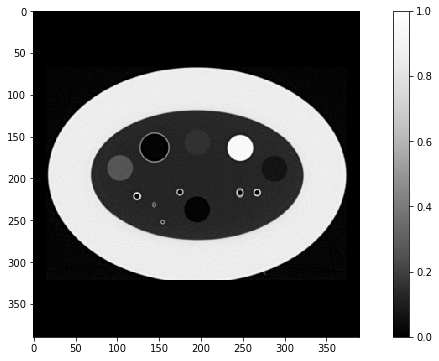

In [157]:
import pydicom as pdc

path="tomography_phantom.dcm"
Im=pdc.dcmread(path)
img=Im.pixel_array

# Selecionar uma região da imagem para remover um artefato
img=img[135:389,80:440]

# Normalizar as intensidades
img=img/np.max(img)

# Tornar a região quadrada
val_pad=15
max_dim=np.max(img.shape)
x_pad=int((max_dim-img.shape[0])/2)+val_pad
y_pad=int((max_dim-img.shape[1])/2)+val_pad
img=np.pad(img,((x_pad,x_pad),(y_pad,y_pad)))

# Plotar a imagem
plt.rcParams['figure.figsize'] = [12, 6]
plt.imshow(img,cmap="Greys_r")
plt.colorbar()
plt.show();

Primeiramente, iremos obter a transformada de Radon dessa imagem com diferentes números de projeções.

C:\Users\guys_\Anaconda3\lib\site-packages\skimage\transform\radon_transform.py:69: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


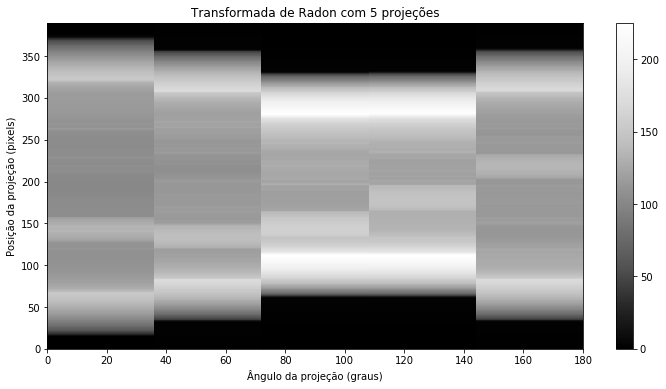

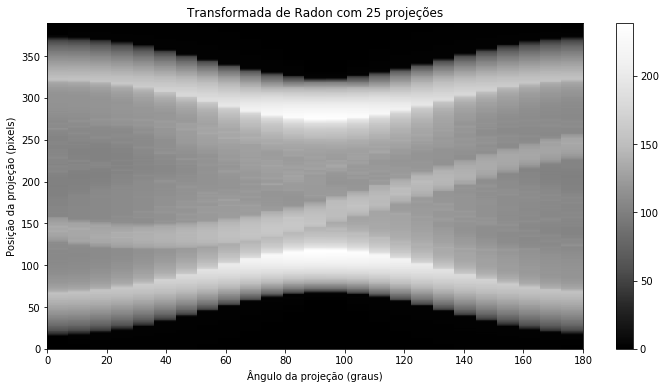

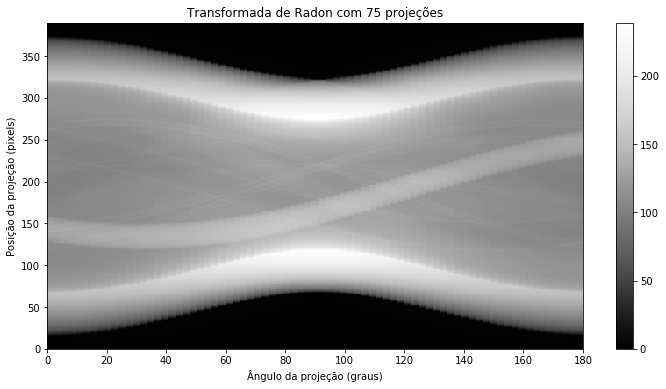

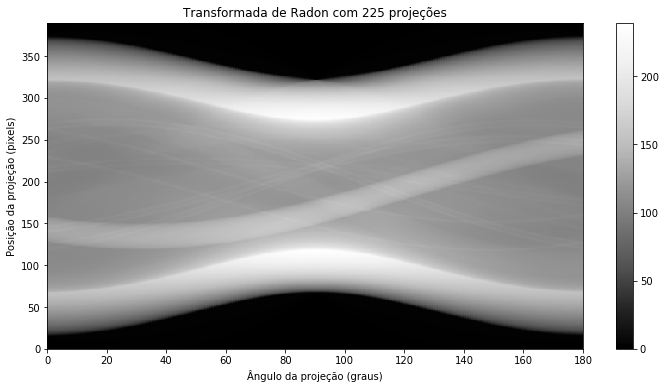

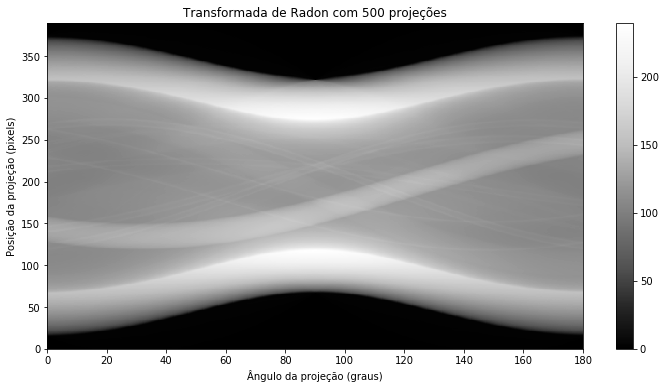

In [158]:
from skimage.transform import radon

# Projeções
proj=[5,25,75,225,500]
theta_vals = {}

for num_proj in proj:
    theta_vals[str(num_proj)]=np.linspace(0,180,num_proj,endpoint=False)

theta = lambda i: theta_vals[str(proj[i])] # Função para pegar valores de theta facilmente

# Cálculo dos sinogramas
sinogram_vals = {}

for p in range(len(proj)):
    sinogram_vals[str(p)]=radon(img, theta=theta(p),circle=True)
    
sinogram = lambda i: sinogram_vals[str(i)]

for i in range(len(proj)):
    plt.imshow(sinogram(i), cmap="Greys_r",extent=(0, 180, 0, sinogram(i).shape[0]), aspect='auto')
    plt.title(f"Transformada de Radon com {len(theta(i))} projeções")
    plt.ylabel("Posição da projeção (pixels)")
    plt.xlabel("Ângulo da projeção (graus)")
    plt.colorbar()
    plt.show();

É possível notar nos sinogramas que, conforme aumentamos o número de projeções utilizadas, o seu aspecto de torna mais contínuo. Iremos agora tentar reconstruir a imagem original aplicando a transformada inversa de Radon sem filtro, com o filtro rampa e com o filtro hamming. Também calcularemos o erro das imagens reconstruidas em relação à imagem original.

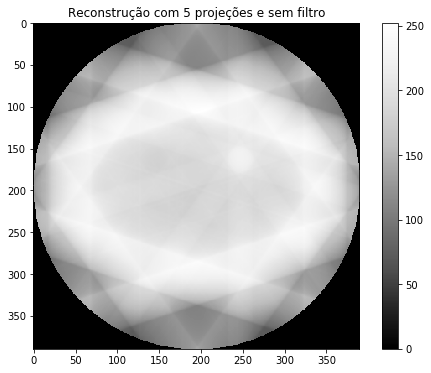

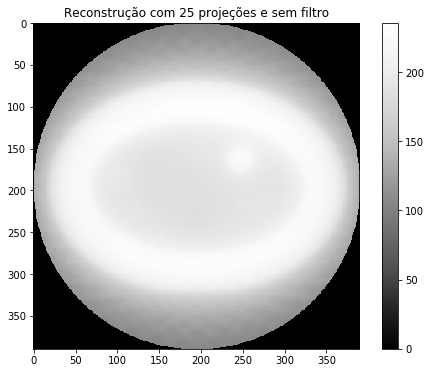

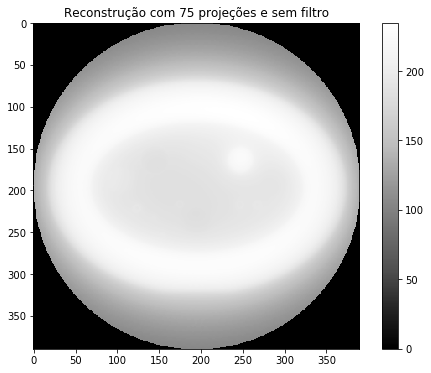

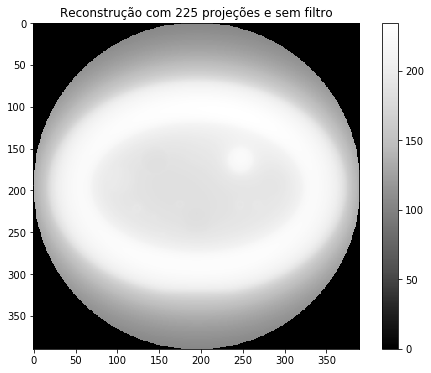

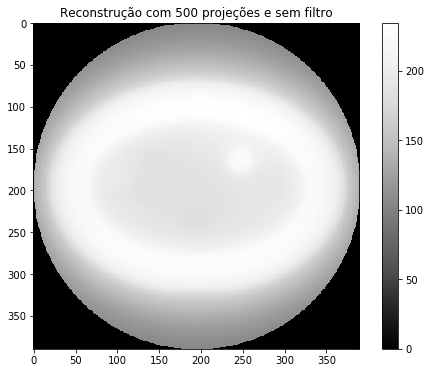

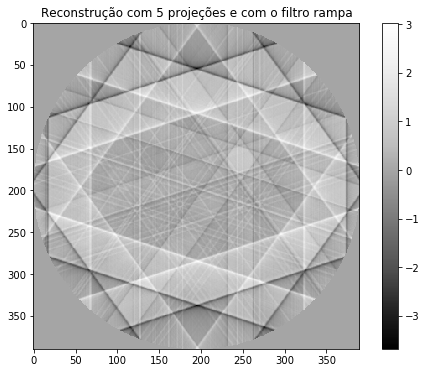

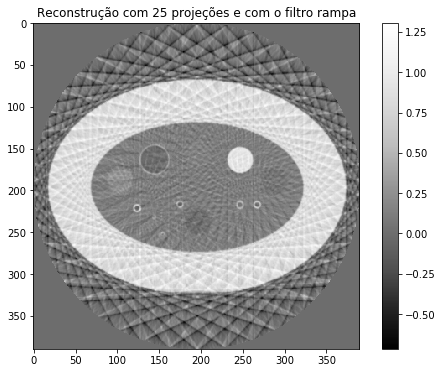

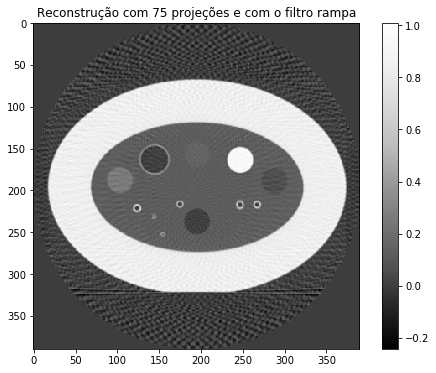

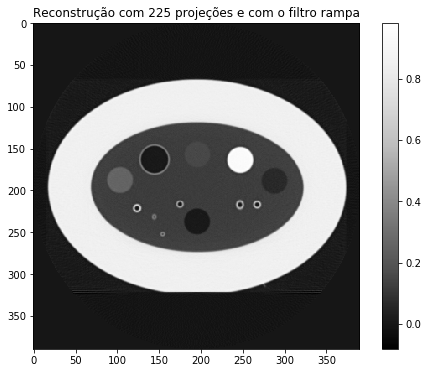

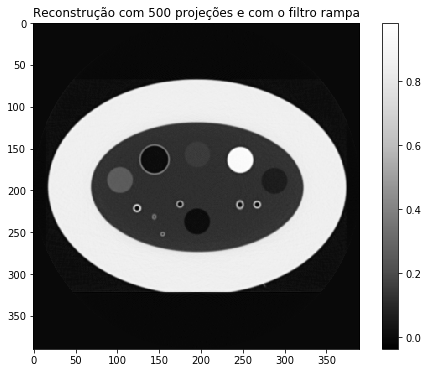

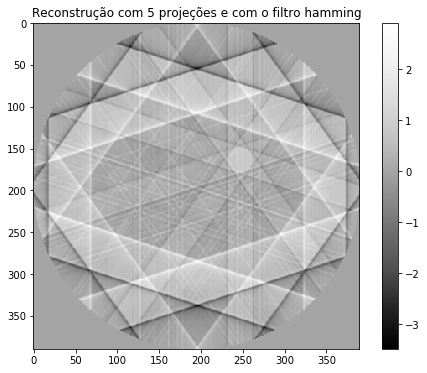

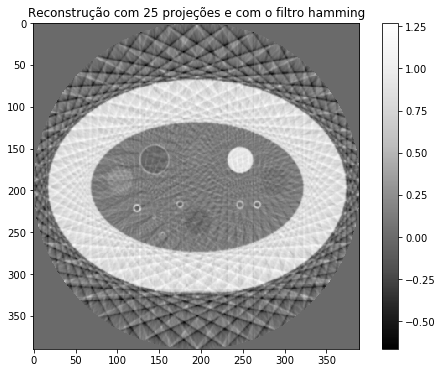

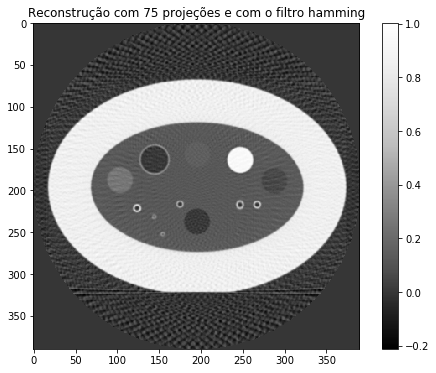

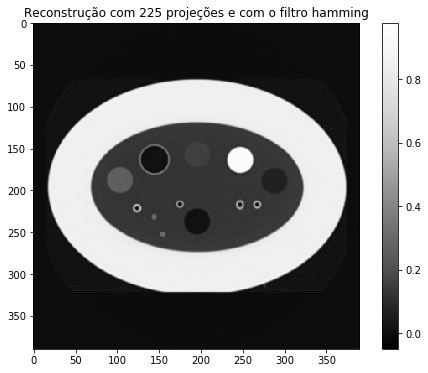

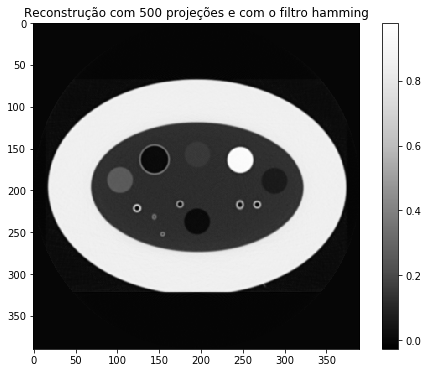

In [159]:
from skimage.transform import iradon

# Filtros
f=[None,'ramp','hamming']
f_label=["sem filtro", "com o filtro rampa", "com o filtro hamming"]

# Criar estrutura para armazenar o erro
error = np.zeros((len(f),len(proj)))

# Calcuar a transformada inversa de radon
plt.rcParams['figure.figsize'] = [8, 6]

for i in range(len(f)):
    for j in range(len(proj)):
        img_rec=iradon(sinogram(j), theta=theta(j), filter=f[i],circle=True)
        plt.imshow(img_rec,cmap="Greys_r")
        plt.title(f"Reconstrução com {len(theta(j))} projeções e {f_label[i]}")
        plt.colorbar()
        plt.show()

        error[i,j]=np.sqrt(np.mean((img-img_rec)**2))

Como pode ser visto, a reconstrução sem a utilização de algum filtro fez com que a imagem resultante apresentasse uma aspecto borrado e com altos valores de intensidade, inclusive na área que correspondia ao fundo. Não foi possível distinguir todas as diferentes regiões da imagem original mesmo com o aumento do número de projeções, o que mostra quão essencial é a utilização de um filtro para a reconstrução de imagens a partir de um sinograma.

Com a utilização dos filtros, foi possível a obtenção de imagens próximas do que se tinha originalmente. Quanto ao número de projeções, com um valor muito baixo (5) a imagem reconstruída possuiu pouca semelhança com a imagem original, com as diferentes regiões não podendo ser distinguidas. Com 25 e 75 projeções já foi possível possível observar essas regiões, porém houve a presença de uma artefato bastante visível com aspecto de linhas ao longo de toda a imagem. Com 225 e 500 projeções, esse artefato diminuiu consideravelmente, e as imagens produzidas com filtros se aproximaram da imagem original.

A tabela apresentada a seguir mostra a raiz quadrada do erro quadrático médio para cada um dos casos produzidos.

In [167]:
import pandas as pd

label_f=["Sem filtro","Rampa","Hamming"]

data_error=pd.DataFrame(np.round(error,3),label_f,proj)

data_error

,5,25,75,225,500
Sem filtro,163.135,162.892,162.891,162.891,162.891
Rampa,0.403,0.115,0.038,0.014,0.013
Hamming,0.392,0.111,0.036,0.016,0.015


Esses valores corroboram a análise feita visualmente, mostrando que a imagem reconstruida sem filtro foi a que apresentou o maior erro, que continuou alto mesmo com o aumento do número de projeções. Quanto às imagens filtradas, os erros obtidos foram próximos, porém é possível notar que o filtro Hamming produziu uma imagem com menor erro até o caso onde foi utilizado 75 projeções. Já quando os valores superiores de projeções foram utilizados, o filtro rampa foi o que produziu a melhor imagem.